## Install and import

In [1]:
# !pip install torch==1.4.0
# !pip install transformers==2.11.0
# !pip install attrdict==2.0.1
!pip install datasets transformers attrdict

     |████████████████████████████████| 225kB 11.7MB/s 
     |████████████████████████████████| 2.1MB 20.7MB/s 
     |████████████████████████████████| 245kB 65.1MB/s 
     |████████████████████████████████| 112kB 73.3MB/s 
     |████████████████████████████████| 3.3MB 71.5MB/s 
     |████████████████████████████████| 901kB 53.5MB/s 


In [22]:
import torch
import torch.nn as nn
from transformers import BertPreTrainedModel, BertModel
from transformers import BertTokenizer
from typing import Union, Optional

import numpy as np
from transformers.pipelines import ArgumentHandler
from transformers import (
    Pipeline,
    PreTrainedTokenizer,
    ModelCard
)
from pprint import pprint
import os
import google.colab as colab
import pandas as pd
import json
from sklearn.metrics import multilabel_confusion_matrix
import matplotlib.pyplot as plt
import random

In [3]:
def mount_google_drive():
	'''
	# Functionality
		Mount google drive. Since colab does not save files, we want to make it easier to directly access files in google drive.
	# Arguments
		Nothing
	# Returns
		drive_root: the working directory mounted
	'''
	mount_directory = "/content/gdrive"
	drive = colab.drive
	drive.mount(mount_directory, force_remount=True)
	drive_root = mount_directory + "/" + list(filter(lambda x: x[0] != '.', os.listdir(mount_directory)))[0]
	return drive_root

ROOT_DIR =  mount_google_drive() + "/goemotion/"
CHECKPOINT_ROOT = ROOT_DIR+ "goemotion-ckpt/original/checkpoint-10000"

Mounted at /content/gdrive


# Load Data

In [20]:
# Load training sentences
train_df = pd.read_csv(ROOT_DIR + "data/original/train.tsv", sep='\t', header=None, names=["sentence", "label", "encoding"])
train_sentences = train_df.sentence.tolist()

In [33]:
# Load labels and build dicts
with open(ROOT_DIR + "data/original/labels.txt", "r") as f:
  labels = f.read().splitlines()
label2index = {v: k for k, v in enumerate(labels)}
index2label = {k: v for k, v in enumerate(labels)}


# Load test set, get test sents and ground truths
test_df = pd.read_csv(ROOT_DIR + "data/original/test.tsv", sep='\t', header=None, names=["sentence", "label", "encoding"])
test_sentences = test_df.sentence.tolist()


# Create ground truth label format
ground_truths = []
for x in test_df.label.tolist():
  single_idxs = x.split(",")
  single_labels = []
  for label in single_idxs:
    single_labels.append(index2label[int(label)])
  ground_truths.append(single_labels)

In [18]:
# Load T5 mapping
with open(ROOT_DIR + "t5.json", 'r') as f:
  t5_map = json.load(f)

In [10]:
len(t5_map.keys())

5421

In [21]:
len(train_sentences)

43410

## Model Class

In [238]:
class BertForMultiLabelClassification(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels

        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, self.config.num_labels)
        self.loss_fct = nn.BCEWithLogitsLoss()

        self.init_weights()

        self.mixing_rate = 0.92

    def forward(
            self,
            input_ids=None,
            attention_mask=None,
            token_type_ids=None,
            candidate_input_ids=None,
            candidate_attention_mask=None,
            candidate_token_type_ids=None,
            position_ids=None,
            head_mask=None,
            inputs_embeds=None,
            labels=None,
    ):
        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
        )
        if candidate_input_ids is not None and candidate_attention_mask is not None and candidate_token_type_ids is not None:
          candidate_outputs = self.bert(
              candidate_input_ids,
              attention_mask=candidate_attention_mask,
              token_type_ids=candidate_token_type_ids,
              position_ids=position_ids,
              head_mask=head_mask,
              inputs_embeds=inputs_embeds,
          )
          pooled_output = self.mixing_rate * outputs[1] + (1 - self.mixing_rate) * candidate_outputs[1]
        else:
          pooled_output = outputs[1]

        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        outputs = (logits,) + outputs[2:]  # add hidden states and attention if they are here

        if labels is not None:
            loss = self.loss_fct(logits, labels)
            outputs = (loss,) + outputs

        return outputs  # (loss), logits, (hidden_states), (attentions)

# Retrieval helpers

In [239]:
#TODO:
# 1. Build bertscore similarity metrics
# 2. Build uda back-translation

In [240]:
def generate_candidates(test_sents, type):
  # for each t5 paraphrase, we have 10; just randomly pick one
  if type == "t5":
    return [t5_map[x][random.randint(0, len(t5_map[x]) - 1)] for x in test_sents]
  else:
    # How about just return random training questions
    random_indexes = random.sample(range(len(train_sentences)), len(test_sents))
    return list(itemgetter(*random_indexes)(train_sentences))

# Inference On Testset

In [241]:
device = 0
threshold = 0.3
tokenizer = BertTokenizer.from_pretrained(CHECKPOINT_ROOT)
model = BertForMultiLabelClassification.from_pretrained(CHECKPOINT_ROOT)
model = model.to(device)

# goemotions = MultiLabelPipeline(
#     model=model,
#     tokenizer=tokenizer,
#     threshold=0.3
# )

def goemotions(test_sents):
  torch.cuda.set_device(device)
  # 1. Get candidate sentences
  candidates = generate_candidates(test_sents, "t5")
  # 2. Tokenizer pass for both test inputs and candidate inputs
  test_inputs = tokenizer(
            test_sents,
            add_special_tokens=True,
            return_tensors="pt",
            padding=True,
            truncation=False,
        )
  
  candidate_inputs = tokenizer(
            candidates,
            add_special_tokens=True,
            return_tensors="pt",
            padding=True,
            truncation=False,
        )
  with torch.no_grad():
    # 3. Model Forward pass
    test_inputs = {name: tensor.to(device) for name, tensor in test_inputs.items()}
    candidate_inputs = {name: tensor.to(device) for name, tensor in candidate_inputs.items()}
    # outputs = model(**inputs)[0].cpu()
    outputs = model(input_ids=test_inputs["input_ids"],
                    attention_mask=test_inputs["attention_mask"],
                    token_type_ids=test_inputs["token_type_ids"],
                    candidate_input_ids=candidate_inputs["input_ids"],
                    candidate_attention_mask=candidate_inputs["attention_mask"],
                    candidate_token_type_ids=candidate_inputs["token_type_ids"],
                    )[0].cpu()
    # 4. Inference output post-processing
    scores = 1 / (1 + np.exp(-outputs))  # Sigmoid
    results = []
    for item in scores:
        labels = []
        scores = []
        for idx, s in enumerate(item):
            if s > threshold:
                labels.append(model.config.id2label[idx])
                scores.append(float(s))
        results.append({"labels": labels, "scores": scores})
    return results


# pprint(test_sentences[:5])
# pprint(goemotions(test_sentences[:5]))

# Output
#  [{'labels': ['neutral'], 'scores': [0.9750906]},
#  {'labels': ['curiosity', 'love'], 'scores': [0.9694574, 0.9227462]},
#  {'labels': ['love'], 'scores': [0.993483]},
#  {'labels': ['anger'], 'scores': [0.99225825]}]

# [{'labels': ['optimism'], 'scores': [0.3206218481063843]},
#  {'labels': ['curiosity', 'love'],
#   'scores': [0.4122002422809601, 0.8766248226165771]},
#  {'labels': ['love'], 'scores': [0.9667580723762512]},
#  {'labels': ['anger'], 'scores': [0.9185698628425598]}]

## Generate and load predictions

In [242]:
prediction_filename = ROOT_DIR + "data/original/t5_predictions_epoch4.json"
# prediction_filename = ROOT_DIR + "data/original/predictions_epoch4.json"

In [243]:
raw_predictions = []
batch_size = 81
num_batches = len(test_sentences) / batch_size

i = 0
while i < len(test_sentences):
  raw_predictions += goemotions(test_sentences[i: i + batch_size])
  i = i + batch_size

with open(prediction_filename, 'w') as f:
  json.dump(raw_predictions, f)

In [244]:
with open(prediction_filename, 'r') as f:
  raw_predictions = json.load(f)

In [245]:
predictions = [x["labels"] for x in raw_predictions]

In [246]:
len(ground_truths) == len(predictions)

True

In [247]:
# num_em = 0
# for i, (pred, truth) in enumerate(zip(predictions, ground_truths)):
#   if pred != truth and "grief" in truth:
#     num_em += 1
#     print(test_sentences[i])
#     print(pred)
#     print(truth)
#     print("------------------")
# # print(num_em / len(predictions))

In [248]:
# num_em = 0
# for i, (pred, truth) in enumerate(zip(predictions, ground_truths)):
#   if pred != truth and "pride" in truth:
#     num_em += 1
#     print(test_sentences[i])
#     print(pred)
#     print(truth)
#     print("------------------")
# # print(num_em / len(predictions))

In [249]:
# num_em = 0
# for i, (pred, truth) in enumerate(zip(predictions, ground_truths)):
#   if pred != truth and "relief" in truth:
#     num_em += 1
#     print(test_sentences[i])
#     print(pred)
#     print(truth)
#     print("------------------")
# # print(num_em / len(predictions))

In [250]:
def convert_onehot(inputs):
  final_arr = np.zeros((len(inputs), len(label2index.keys())))
  for i, labels in enumerate(inputs):
    for label in labels:
      final_arr[i, label2index[label]] = 1
  return final_arr

In [251]:
onehot_truths = convert_onehot(ground_truths)
onehot_preds = convert_onehot(predictions)

In [252]:
multilabel_confmat = multilabel_confusion_matrix(onehot_truths, onehot_preds)

In [253]:
cls_report = {}
for i in range(multilabel_confmat.shape[0]):
  cls_report[index2label[i]] = {}
  cls_report[index2label[i]]["tn"] = multilabel_confmat[i, 0, 0] + 0.01
  cls_report[index2label[i]]["fp"] = multilabel_confmat[i, 0, 1] + 0.01
  cls_report[index2label[i]]["fn"] = multilabel_confmat[i, 1, 0] + 0.01
  cls_report[index2label[i]]["tp"] = multilabel_confmat[i, 1, 1] + 0.01
  cls_report[index2label[i]]["total"] = cls_report[index2label[i]]["tp"] + cls_report[index2label[i]]["fn"]
  cls_report[index2label[i]]["precision"] = cls_report[index2label[i]]["tp"] / (cls_report[index2label[i]]["fp"] + cls_report[index2label[i]]["tp"])
  cls_report[index2label[i]]["recall"] = cls_report[index2label[i]]["tp"] / (cls_report[index2label[i]]["fn"] + cls_report[index2label[i]]["tp"])
  cls_report[index2label[i]]["f1"] = 2 * cls_report[index2label[i]]["precision"] * cls_report[index2label[i]]["recall"] / (cls_report[index2label[i]]["precision"] + cls_report[index2label[i]]["recall"])

In [254]:
cls_report

{'admiration': {'f1': 0.6738481995256235,
  'fn': 129.01,
  'fp': 234.01,
  'precision': 0.6157597451643624,
  'recall': 0.7440379350025793,
  'tn': 4689.01,
  'total': 504.02,
  'tp': 375.01},
 'amusement': {'f1': 0.8090063190056247,
  'fn': 31.01,
  'fp': 79.01,
  'precision': 0.7467790526248318,
  'recall': 0.8825467767593365,
  'tn': 5084.01,
  'total': 264.02,
  'tp': 233.01},
 'anger': {'f1': 0.49878946349021885,
  'fn': 95.01,
  'fp': 112.01,
  'precision': 0.4790717142591387,
  'recall': 0.5201999798000202,
  'tn': 5117.01,
  'total': 198.02,
  'tp': 103.01},
 'annoyance': {'f1': 0.37160896622560574,
  'fn': 197.01,
  'fp': 219.01,
  'precision': 0.35965732998070293,
  'recall': 0.3843822261108681,
  'tn': 4888.01,
  'total': 320.02,
  'tp': 123.01},
 'approval': {'f1': 0.39499888740542943,
  'fn': 209.01,
  'fp': 226.01,
  'precision': 0.3858757676213249,
  'recall': 0.40456384251609595,
  'tn': 4850.01,
  'total': 351.02,
  'tp': 142.01},
 'caring': {'f1': 0.43543388429752067

In [255]:
def get_attr_class(cls_report, metric_name):
  return [x[metric_name] for x in list(cls_report.values())]

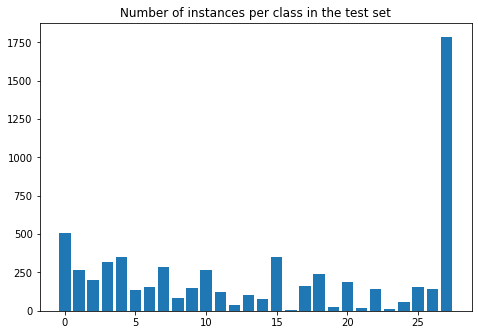

In [256]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title('Number of instances per class in the test set')
metric_name = "total"
ax.bar(list(label2index.values()), [x[metric_name] for x in list(cls_report.values())])
plt.show()

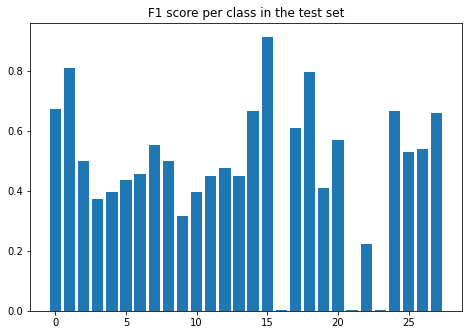

In [257]:
# make two columns
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title('F1 score per class in the test set')
metric_name = "f1"
ax.bar(list(label2index.values()), [x[metric_name] for x in list(cls_report.values())])
plt.show()

In [258]:
sum([x[metric_name] for x in list(cls_report.values())]) / len([x[metric_name] for x in list(cls_report.values())])

0.47744574588883876

In [ ]:
# 0.4756